# Group 42 Master Notebook
**Team Members:** Peter Flo Grinde-Hollevik, Chase Hertel, Jordan Taqi-Eddin, Ming Senn Teo <br>
In this notebook, we compiled all of our code for our final project.

## Causal Inference

In [3]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import warnings

np.random.seed(29)
warnings.filterwarnings("ignore")

## Data Preparation

In [5]:
accidents = pd.read_csv('./data/ms_ar_accidents.csv')

pop_data = pd.read_csv('./data/county_pop_data.csv', encoding = 'latin-1')
pop_20_23 = pd.read_csv('./data/county_pop_data_20_23.csv', encoding = 'latin-1')

condition = (pop_data['STNAME'].isin(['Arkansas', 'Mississippi'])) & (pop_data['COUNTY'] != 0)
pop_data = pop_data[condition].reset_index(drop = True)

condition = (pop_20_23['STNAME'].isin(['Arkansas', 'Mississippi'])) & (pop_20_23['COUNTY'] != 0)
pop_20_23 = pop_20_23[condition].reset_index(drop = True)

pop_data = pop_data.merge(pop_20_23, 
                          left_on = ['STNAME', 'CTYNAME'],
                          right_on = ['STNAME', 'CTYNAME']).set_index(['STNAME', 'CTYNAME']).filter(regex = '^POPESTIMATE').reset_index()

pop_data['STABV'] = ['AR' if s == 'Arkansas' else 'MS' for s in pop_data['STNAME']]
pop_data['CTYNAME'] = pop_data['CTYNAME'].str.replace('County', '').str.strip()

In [6]:
light_cols = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
accidents.loc[:, light_cols] = (accidents[light_cols] == 'Day').astype(int)
accidents['Start_Time'] = pd.to_datetime(accidents['Start_Time'], format = 'mixed')
accidents['End_Time'] = pd.to_datetime(accidents['End_Time'], format = 'mixed')

### Only have one month from from 2023, so were dropping it
accidents = accidents[accidents['Start_Time'].dt.year < 2023].reset_index(drop = True)

In [7]:
agg_cols = ['Severity', 'Temperature(F)', 'Wind_Chill(F)',
            'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
            'Wind_Speed(mph)', 'Precipitation(in)', 'Bump', 
            'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
            'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
            'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

### So that we can to necessary aggregations
accidents.loc[:, agg_cols] = accidents[agg_cols].fillna(0)
agg_opps = {'ID' : 'count'}
for c in agg_cols: agg_opps[c] = 'mean'

In [8]:
accidents_y = accidents.groupby(['State', pd.Grouper(key = 'Start_Time', freq = 'Y')]).agg(agg_opps).rename(columns = {'ID' : 'Count'})
accidents_y.reset_index(inplace = True, names = ['State', 'Year'])
accidents_y['Pop_Estimate'] = accidents_y.apply(lambda row : pop_data[f"POPESTIMATE{row['Year'].year}"].sum(), axis = 1)

In [9]:
pop_data.groupby('STNAME').agg({'POPESTIMATE2020':np.sum})

,POPESTIMATE2020
STNAME,
Arkansas,3014348
Mississippi,2958409


In [10]:
accidents_m = accidents.groupby(['State', pd.Grouper(key = 'Start_Time', freq = 'M')]).agg(agg_opps).rename(columns = {'ID' : 'Count'})
accidents_m.reset_index(inplace = True, names = ['State', 'Month'])
accidents_m['Pop_Estimate'] = accidents_m.apply(lambda row : pop_data[f"POPESTIMATE{row['Month'].year}"].sum(), axis = 1)

In [11]:
accidents_wk = accidents.groupby(['State', pd.Grouper(key = 'Start_Time', freq = 'W')]).agg(agg_opps).rename(columns = {'ID' : 'Count'})
accidents_wk.reset_index(inplace = True, names = ['State', 'Week'])
accidents_wk['Pop_Estimate'] = accidents_wk.apply(lambda row : pop_data[f"POPESTIMATE{row['Week'].year}"].sum(), axis = 1)

## Initial Visualizations

### Monthly Totals and Mean Severities

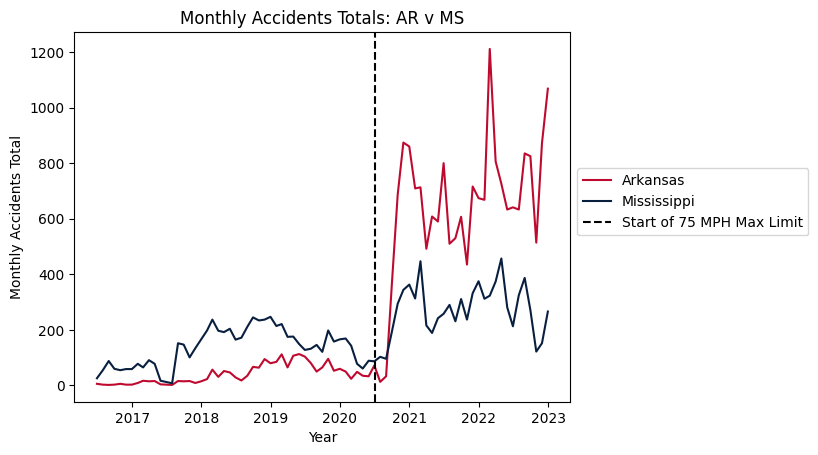

In [14]:
df = accidents_m
a784 = datetime(2020, 7, 1, 0, 0, 0)

state_colors = {'AR': '#BF0A30', 'MS': '#081F40'}

state = 'AR'
sns.lineplot(data = df[df['State'] == state],
             x = 'Month', y = 'Count', color = state_colors[state], label = 'Arkansas')

state = 'MS'
sns.lineplot(data = df[df['State'] == state],
             x = 'Month', y = 'Count', color = state_colors[state], label = 'Mississippi')
plt.axvline(a784, color = 'black', ls = '--', label = 'Start of 75 MPH Max Limit')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 0.65))
plt.xlabel('Year')
plt.ylabel('Monthly Accidents Total')
plt.title('Monthly Accidents Totals: AR v MS')
plt.show();

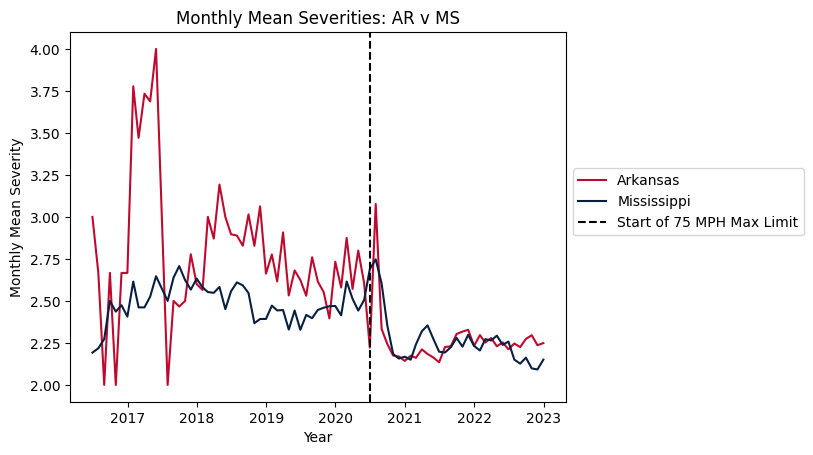

In [15]:
df = accidents_m

state = 'AR'
sns.lineplot(data = df[df['State'] == state],
             x = 'Month', y = 'Severity', color = state_colors[state], label = 'Arkansas')

state = 'MS'
sns.lineplot(data = df[df['State'] == state],
             x = 'Month', y = 'Severity', color = state_colors[state], label = 'Mississippi')
plt.axvline(a784, color = 'black', ls = '--', label = 'Start of 75 MPH Max Limit')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 0.65))
plt.xlabel('Year')
plt.ylabel('Monthly Mean Severity')
plt.title('Monthly Mean Severities: AR v MS')
plt.show();

### County Distributions

In [17]:
accidents_county_yr = accidents.groupby(['State', 'County', pd.Grouper(key = 'Start_Time', freq = 'Y')]).agg(agg_opps).rename(columns = {'ID' : 'Count'})
accidents_county_yr.reset_index(inplace = True, names = ['State', 'County', 'Year'])

accidents_county_yr_all = accidents_county_yr.copy()

### Only keeps counties we have a population for
accidents_county_yr = accidents_county_yr.merge(pop_data[['STABV', 'CTYNAME']], 
                          left_on = ['State', 'County'], 
                          right_on = ['STABV', 'CTYNAME'])

accidents_county_yr['Pop_Estimate'] = accidents_county_yr.apply(lambda row : pop_data.set_index(['STABV',
                                                                                   'CTYNAME']).loc[(row['State'],
                                                                                                    row['County']),
                                                                                                   f"POPESTIMATE{row['Year'].year}"], axis = 1)

In [18]:
yrs = sorted(accidents_county_yr['Year'].unique())
all_counties = pd.DataFrame(data = accidents[['State', 'County']]).drop_duplicates().reset_index(drop = True)
all_combos = pd.MultiIndex.from_product([accidents['State'].unique(), 
                                           accidents['County'].unique(),
                                          yrs], 
                                          names=['State', 'County', 'Year'])
all_combos = pd.DataFrame(index = all_combos).reset_index()
all_combos = all_counties.merge(all_combos, left_on = ['State', 'County'], right_on = ['State', 'County'])

In [19]:
accidents_county_yr = all_combos.merge(accidents_county_yr, how = 'left', left_on = ['State', 'County', 'Year'], right_on = ['State', 'County', 'Year'])
accidents_county_yr['Count'] = accidents_county_yr['Count'].fillna(0)

accidents_county_yr_all = all_combos.merge(accidents_county_yr_all, how = 'left', left_on = ['State', 'County', 'Year'], right_on = ['State', 'County', 'Year'])
accidents_county_yr_all['Count'] = accidents_county_yr_all['Count'].fillna(0)
accidents_county_yr_all['Severity'] = accidents_county_yr_all['Severity'].fillna(0)

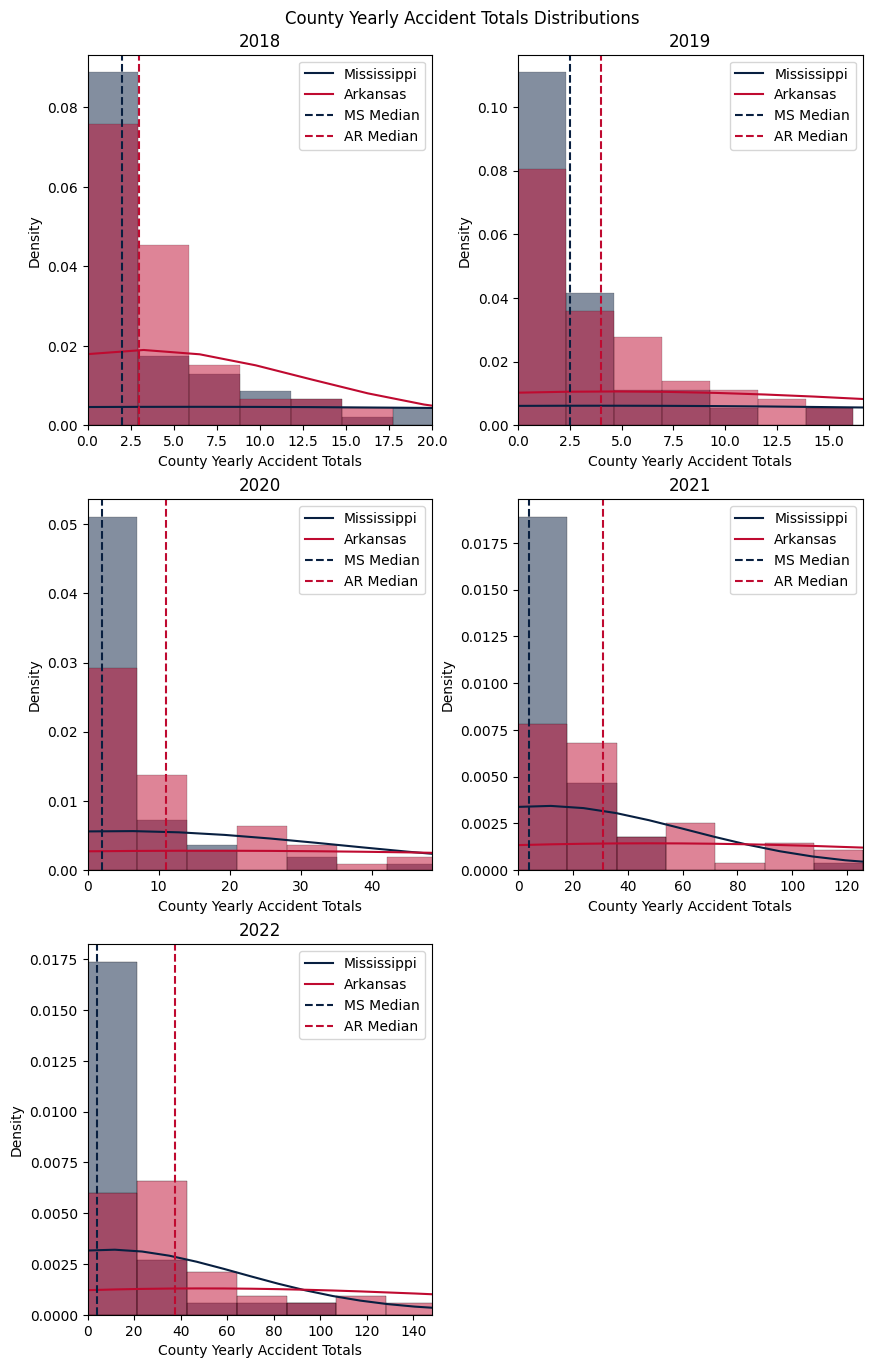

*NOTE: Plots are zoomed in to exclude outliers.


In [20]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
df = accidents_county_yr_all
stat = 'Count'
axs = axs.flatten()

states_palette = ['#BF0A30', '#081F40']

for i, ax in enumerate(axs):
    if i != 5:
        plot_df = df[df['Year'] == yrs[i + 2]]

        sns.histplot(data = plot_df, x = stat, stat = 'density', hue = 'State', palette = states_palette,
                     kde = True, ax = ax)


        Q1 = plot_df[stat].quantile(0.25)

        Q3 = plot_df[stat].quantile(0.75)

        IQR = Q3 - Q1

        upper_bound = Q3 + 1.5 * IQR

        ar_med = plot_df[plot_df['State'] == 'AR'][stat].median()
        ms_med = plot_df[plot_df['State'] == 'MS'][stat].median()

        ax.axvline(ms_med, color = state_colors['MS'], ls = '--', label = 'MS Median')
        ax.axvline(ar_med, color = state_colors['AR'], ls = '--', label = 'AR Median')

        ax.set_xlim(0, upper_bound)
        ax.legend(labels = ['Mississippi', 'Arkansas', 'MS Median', 'AR Median'])
        ax.set_xlabel('County Yearly Accident Totals')
        ax.set_title(datetime.strptime(str(yrs[i + 2]), '%Y-%m-%d %H:%M:%S').year)
    else:
        ax.set_visible(False)

fig.suptitle('County Yearly Accident Totals Distributions')
plt.subplots_adjust(wspace = 0.25, top = 0.95)
plt.show();
print('*NOTE: Plots are zoomed in to exclude outliers.')

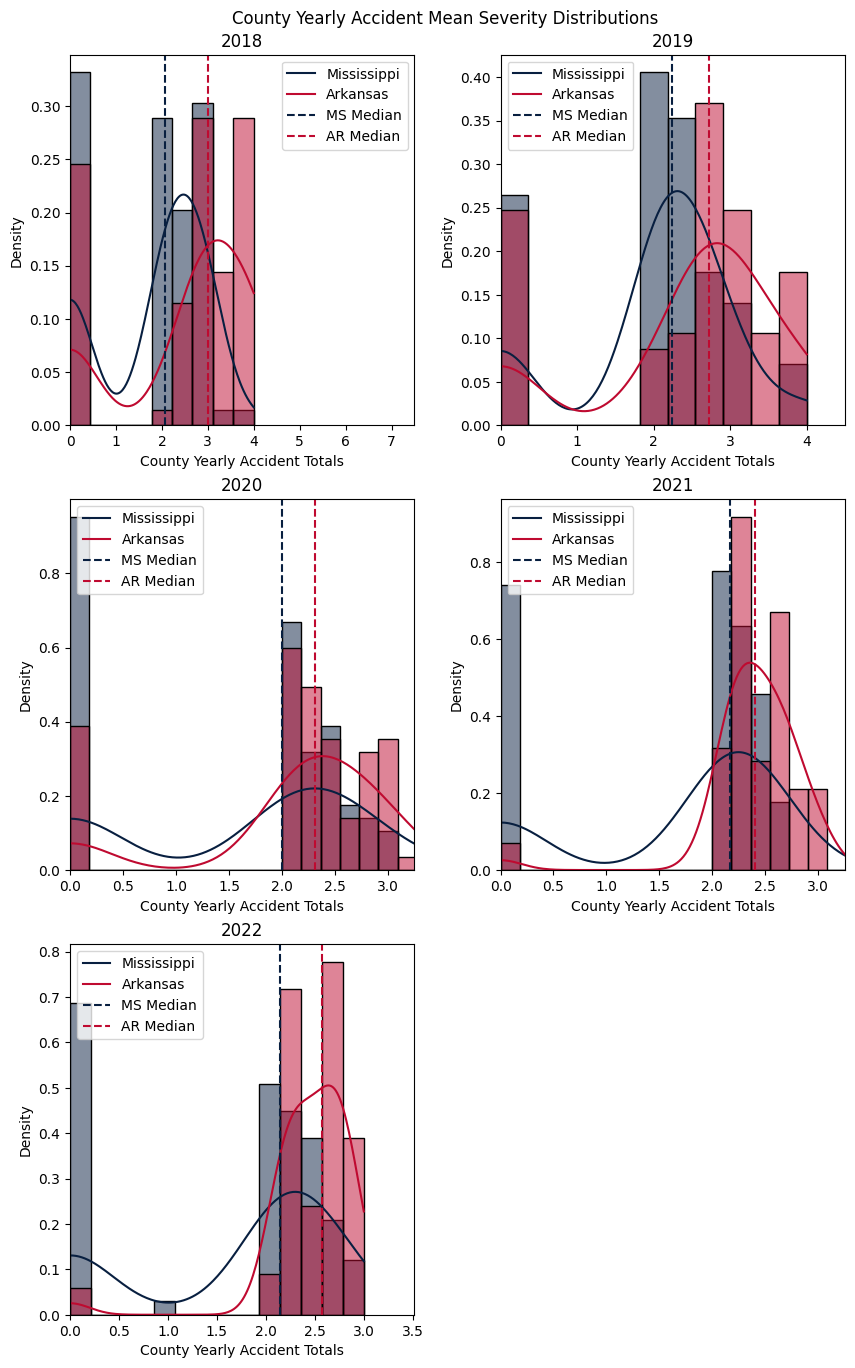

*NOTE: Plots are zoomed in to exclude outliers.


In [21]:
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
df = accidents_county_yr_all
stat = 'Severity'
axs = axs.flatten()

states_palette = ['#BF0A30', '#081F40']

for i, ax in enumerate(axs):
    if i != 5:
        plot_df = df[df['Year'] == yrs[i + 2]]

        sns.histplot(data = plot_df, x = stat, stat = 'density', hue = 'State', palette = states_palette,
                     kde = True, ax = ax)


        Q1 = plot_df[stat].quantile(0.25)

        Q3 = plot_df[stat].quantile(0.75)

        IQR = Q3 - Q1

        upper_bound = Q3 + 1.5 * IQR

        ar_med = plot_df[plot_df['State'] == 'AR'][stat].median()
        ms_med = plot_df[plot_df['State'] == 'MS'][stat].median()

        ax.axvline(ms_med, color = state_colors['MS'], ls = '--', label = 'MS Median')
        ax.axvline(ar_med, color = state_colors['AR'], ls = '--', label = 'AR Median')

        ax.set_xlim(0, upper_bound)
        ax.legend(labels = ['Mississippi', 'Arkansas', 'MS Median', 'AR Median'])
        ax.set_xlabel('County Yearly Accident Totals')
        ax.set_title(datetime.strptime(str(yrs[i + 2]), '%Y-%m-%d %H:%M:%S').year)
    else:
        ax.set_visible(False)

fig.suptitle('County Yearly Accident Mean Severity Distributions')
plt.subplots_adjust(wspace = 0.25, top = 0.95)
plt.show();
print('*NOTE: Plots are zoomed in to exclude outliers.')

### Modeling

### Model - State-Level
$Y_{s, t, y} = \beta_0 (\textit{Limit Raised}_{t, y} \times \textit{Arkansas}_{s}) + \beta_1 (Population)_{s, t} + \lambda_{s, t, y} + \kappa_{s, t, y} + \epsilon_{s, t, t}$
- $Y_{m,t} \text{ = Accident Total in state } s \text{ during time-period } t \text{ and year } y \text{;} \hspace{0.1cm} \textbf{Note: } \text{time-period } t \text{ can either be monthly or yearly}$
- $\textit{Limit Raised}_{t, y} \text{ = Binary Indicator for whether Arkansas Law, Act 784 had went into effect (i.e. Any time after July 1, 2020)}$
- $\textit{Arkansas}_{s} \text{ = Binary Indicator for whether state } s \text{ is Arkansas}$
- $\textit{Population}_{s, t} \text{ = Log Population estimate of state } s \text{ during year } y$
- $\lambda_{s, t, y} \text{ = Vector of Location-Based Fixed-Effects for state } s \text{ during time-period } t \text{ and year } y \text{ (e.g. Traffic Signal, Junction, Crossing, etc.)}$
- $\kappa_{s, t, y} \text{ = Vector of Weather-Based Fixed-Effects for state } s \text{ during time-period } t \text{ and year } y \text{ (e.g. Temperature, Visibility, Wind_Speed, etc.)}$

$\text{Additionally},$

$$
Y_{s, t, y} | \beta \sim \text{NegBin}(\exp(x_i^T \beta))
$$

In [24]:
location_cols = ['Temperature(F)', 'Wind_Chill(F)',
                 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
                 'Wind_Speed(mph)', 'Precipitation(in)']
weather_cols = ['Bump', 'Crossing', 'Give_Way', 'Junction', 
                'No_Exit', 'Railway', 'Roundabout', 'Station', 
                'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

### Feature Engineering

In [26]:
def fit_negative_binomial_model(df, target_variable, explanatory_variables, 
                                intercept = False, 
                                alpha = 1):
    target = df[target_variable]
    inputs = df[explanatory_variables]
    
    if intercept:
        inputs = sm.add_constant(inputs)
    
    # Fit the negative binomial regression model
    fitted_model = sm.GLM(target, inputs, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
    
    return fitted_model

In [27]:
### We use > and not >= b/c aggregation on the last day of the
### agg-period (i.e. End of the week, month, etc.)
accidents_m['Log_Pop_Estimate'] = np.log(accidents_m['Pop_Estimate'])
accidents_m['Limit_Raised'] = (accidents_m['Month'] > a784).astype(int)
accidents_m['Arkansas'] = (accidents_m['State'] == 'AR').astype(int)
accidents_m['Limit_Raised_Arkansas'] = accidents_m['Limit_Raised'] * accidents_m['Arkansas']

am_rev = accidents_m[accidents_m['Month'].dt.year >= 2018].reset_index(drop = True)

accidents_wk['Log_Pop_Estimate'] = np.log(accidents_wk['Pop_Estimate'])
accidents_wk['Limit_Raised'] = (accidents_wk['Week'] > a784).astype(int)
accidents_wk['Arkansas'] = (accidents_wk['State'] == 'AR').astype(int)
accidents_wk['Limit_Raised_Arkansas'] = accidents_wk['Limit_Raised'] * accidents_wk['Arkansas']
awk_rev = accidents_wk[accidents_wk['Week'].dt.year >= 2018].reset_index(drop = True)

accidents_county_yr['Log_Pop_Estimate'] = np.log(accidents_county_yr['Pop_Estimate'])
accidents_county_yr['Limit_Raised'] = (accidents_county_yr['Year'].dt.year > 2020).astype(int)

# In line with Deschênes et al. 2017
accidents_county_yr.loc[accidents_county_yr['Year'].dt.year == 2020, 'Limit_Raised'] = 0.5

accidents_county_yr['Arkansas'] = (accidents_county_yr['State'] == 'AR').astype(int)
accidents_county_yr['Limit_Raised_Arkansas'] = accidents_county_yr['Limit_Raised'] * accidents_county_yr['Arkansas']

acy_rev = accidents_county_yr[accidents_county_yr['Year'].dt.year >= 2018].reset_index(drop = True)

#### Preliminary Crash Model (*No F.E.'s*)

In [29]:
df = am_rev
target_variable = 'Count'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
model = fit_negative_binomial_model(df, target_variable, explanatory_variables)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                  120
Model:                            GLM   Df Residuals:                      118
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -777.15
Date:                Sun, 05 May 2024   Deviance:                       56.390
Time:                        23:21:18   Pearson chi2:                     39.9
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3297
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Limit_Raised_Arkansas     1.34

### Moving Average Smoothing

In [31]:
def moving_average(data, window_size):
    ma = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i+window_size]
        ma.append(sum(window) / window_size)
    return ma

def add_mas(stat, freq, state, ma_size = 'Quarterly'):
    window_size = 1
    if freq == 'Month':
        if ma_size == 'Annually':
            window_size = 12
        elif ma_size == 'Bi-Annually':
            window_size = 6
        elif ma_size == 'Bi-Monthly':
            window_size = 2
        else:
            window_size = 3 # Monthly Quartely Moving-Average
            
            

        og_df = am_rev
        df = og_df[(og_df['State'] == state)].set_index([freq])[[stat]]

        mas = moving_average(df[stat], window_size)

        og_df.loc[(og_df['State'] == state) & (og_df[freq].isin(df.iloc[window_size - 1:, :].index)), f'{stat}_MA'] = mas
        # og_df.loc[(og_df['State'] == state) & (og_df[f'{stat}_MA'] == 0), f'{stat}_MA'] = og_df.loc[(og_df[freq] == state) & (og_df[f'{stat}_MA'] == 0), stat]
    elif freq == 'Week':
        if freq == 'Month':
            if ma_size == 'Annually':
                window_size = 52
            elif ma_size == 'Bi-Annually':
                window_size = 26
            elif ma_size == 'Bi-Monthly':
                window_size = 8 # This is an approximation
            else:
                window_size = 13 # Monthly Quartely Moving-Average

        og_df = awk_rev
        df = og_df[(og_df['State'] == state)].set_index([freq])[[stat]]

        mas = moving_average(df[stat], window_size)

        og_df.loc[(og_df['State'] == state) & (og_df[freq].isin(df.iloc[window_size - 1:, :].index)), f'{stat}_MA'] = mas
        # og_df.loc[(og_df['State'] == state) & (og_df[f'{stat}_MA'] == 0), f'{stat}_MA'] = og_df.loc[(og_df[freq] == state) & (og_df[f'{stat}_MA'] == 0), stat]
        

#### Counts

In [33]:
stat = 'Count'
am_rev[f'{stat}_MA'] = np.nan
am_rev[f'{stat}_MA'] = np.nan
awk_rev[f'{stat}_MA'] = np.nan
awk_rev[f'{stat}_MA'] = np.nan
ma_size = 'Quarterly'

##### Arkansas (Monthly)

In [35]:
state = 'AR'
freq = 'Month'
add_mas(stat, freq, state, ma_size)

##### Arkansas (Weekly)

In [37]:
state = 'AR'
freq = 'Week'
add_mas(stat, freq, state, ma_size)

##### Mississippi (Monthly)

In [39]:
state = 'MS'
freq = 'Month'
add_mas(stat, freq, state, ma_size)

##### Mississippi (Weekly)

In [41]:
state = 'MS'
freq = 'Week'
add_mas(stat, freq, state, ma_size)

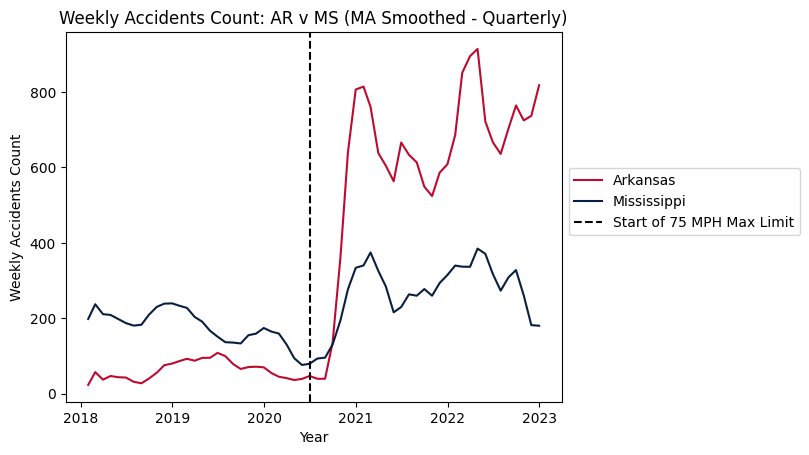

In [42]:
freq = 'Week'
df = am_rev

df[f'{stat}_MA'] = df[f'{stat}_MA'].fillna(df[stat])

y_stat = f'{stat}_MA'

state = 'AR'
sns.lineplot(data = df[df['State'] == state],
             x = 'Month', y = y_stat, color = state_colors[state], label = 'Arkansas')

state = 'MS'
sns.lineplot(data = df[df['State'] == state],
             x = 'Month', y = y_stat, color = state_colors[state], label = 'Mississippi')
plt.axvline(a784, color = 'black', ls = '--', label = 'Start of 75 MPH Max Limit')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 0.65))
plt.xlabel('Year')
plt.ylabel(f'{freq}ly Accidents {stat}')
plt.title(f'{freq}ly Accidents {stat}: AR v MS (MA Smoothed - {ma_size})')
plt.show();

#### Severity

In [44]:
stat = 'Severity'
am_rev[f'{stat}_MA'] = np.nan
am_rev[f'{stat}_MA'] = np.nan
awk_rev[f'{stat}_MA'] = np.nan
awk_rev[f'{stat}_MA'] = np.nan
ma_size = 'Quarterly'

##### Arkansas (Monthly)

In [46]:
state = 'AR'
freq = 'Month'
add_mas(stat, freq, state, ma_size)

##### Arkansas (Weekly)

In [48]:
state = 'AR'
freq = 'Week'
add_mas(stat, freq, state, ma_size)

##### Mississippi (Monthly)

In [50]:
state = 'MS'
freq = 'Month'
add_mas(stat, freq, state, ma_size)

##### Mississippi (Weekly)

In [52]:
state = 'MS'
freq = 'Week'
add_mas(stat, freq, state, ma_size)

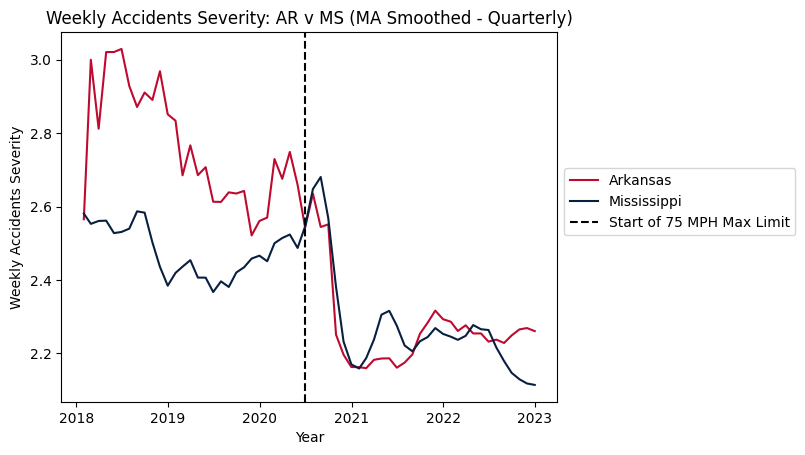

In [53]:
freq = 'Week'
df = am_rev

df[f'{stat}_MA'] = df[f'{stat}_MA'].fillna(df[stat])

y_stat = f'{stat}_MA'

state = 'AR'
sns.lineplot(data = df[df['State'] == state],
             x = 'Month', y = y_stat, color = state_colors[state], label = 'Arkansas')

state = 'MS'
sns.lineplot(data = df[df['State'] == state],
             x = 'Month', y = y_stat, color = state_colors[state], label = 'Mississippi')
plt.axvline(a784, color = 'black', ls = '--', label = 'Start of 75 MPH Max Limit')
plt.legend(loc = 'upper left', bbox_to_anchor = (1, 0.65))
plt.xlabel('Year')
plt.ylabel(f'{freq}ly Accidents {stat}')
plt.title(f'{freq}ly Accidents {stat}: AR v MS (MA Smoothed - {ma_size})')
plt.show();

### Model *cont.*

#### Preliminary Crash Model (*No F.E.'s, MA_Smoothed*)

In [56]:
df = am_rev
target_variable = 'Count_MA'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
model = fit_negative_binomial_model(df, target_variable, explanatory_variables)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Count_MA   No. Observations:                  120
Model:                            GLM   Df Residuals:                      118
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -775.57
Date:                Sun, 05 May 2024   Deviance:                       50.824
Time:                        23:21:20   Pearson chi2:                     35.5
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3097
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Limit_Raised_Arkansas     1.29

#### Crash Model (*Location F.E.'s*)

In [58]:
df = am_rev
target_variable = 'Count'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
explanatory_variables.extend(location_cols)
model = fit_negative_binomial_model(df, target_variable, explanatory_variables)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                  120
Model:                            GLM   Df Residuals:                      111
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -773.05
Date:                Sun, 05 May 2024   Deviance:                       48.193
Time:                        23:21:21   Pearson chi2:                     39.2
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3739
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Limit_Raised_Arkansas     1.40

#### Crash Model (*Weather F.E.'s*)

In [60]:
df = am_rev
target_variable = 'Count'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
explanatory_variables.extend(weather_cols)
model = fit_negative_binomial_model(df, target_variable, explanatory_variables)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                  120
Model:                            GLM   Df Residuals:                      110
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -772.41
Date:                Sun, 05 May 2024   Deviance:                       46.912
Time:                        23:21:21   Pearson chi2:                     35.8
No. Iterations:                    13   Pseudo R-squ. (CS):             0.3806
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Limit_Raised_Arkansas     1.41

#### Crash Model (*Location & Weather F.E.'s*)

In [62]:
df = am_rev
target_variable = 'Count'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
explanatory_variables.extend(location_cols)
explanatory_variables.extend(weather_cols)
model = fit_negative_binomial_model(df, target_variable, explanatory_variables)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                  120
Model:                            GLM   Df Residuals:                      103
Model Family:        NegativeBinomial   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -768.79
Date:                Sun, 05 May 2024   Deviance:                       39.687
Time:                        23:21:21   Pearson chi2:                     32.8
No. Iterations:                    15   Pseudo R-squ. (CS):             0.4168
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Limit_Raised_Arkansas     1.41

#### Crash Model (*Location F.E.'s, MA_Smoothed*)

In [64]:
df = am_rev
target_variable = 'Count_MA'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
explanatory_variables.extend(location_cols)
model = fit_negative_binomial_model(df, target_variable, explanatory_variables)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Count_MA   No. Observations:                  120
Model:                            GLM   Df Residuals:                      111
Model Family:        NegativeBinomial   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -770.42
Date:                Sun, 05 May 2024   Deviance:                       40.525
Time:                        23:21:21   Pearson chi2:                     33.0
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3665
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Limit_Raised_Arkansas     1.34

#### Crash Model (*Weather F.E.'s, MA_Smoothed*)

In [66]:
df = am_rev
target_variable = 'Count_MA'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
explanatory_variables.extend(weather_cols)
model = fit_negative_binomial_model(df, target_variable, explanatory_variables)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Count_MA   No. Observations:                  120
Model:                            GLM   Df Residuals:                      110
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -769.89
Date:                Sun, 05 May 2024   Deviance:                       39.469
Time:                        23:21:21   Pearson chi2:                     32.1
No. Iterations:                    10   Pseudo R-squ. (CS):             0.3720
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Limit_Raised_Arkansas     1.41

#### Crash Model (*Location & Weather F.E.'s, MA_Smoothed*)

In [68]:
df = am_rev
target_variable = 'Count_MA'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
explanatory_variables.extend(location_cols)
explanatory_variables.extend(weather_cols)
model = fit_negative_binomial_model(df, target_variable, explanatory_variables)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Count_MA   No. Observations:                  120
Model:                            GLM   Df Residuals:                      103
Model Family:        NegativeBinomial   Df Model:                           16
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -766.03
Date:                Sun, 05 May 2024   Deviance:                       31.741
Time:                        23:21:21   Pearson chi2:                     26.9
No. Iterations:                    12   Pseudo R-squ. (CS):             0.4112
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Limit_Raised_Arkansas     1.35

### Model - County-Level

$Y_{c, t, y} = \beta_0 (\textit{Limit Raised}_{t, y} \times \textit{Arkansas}_{c}) + \beta_1 (Population)_{c, t} + \lambda_{c, t, y} + \kappa_{c, t, y} + \epsilon_{c, t, t}$
- $Y_{m,t} \text{ = Accident Total in county } c \text{ during time-period } t \text{ and year } y \text{;} \hspace{0.1cm} \textbf{Note: } \text{time-period } t \text{ can either be monthly or yearly}$
- $\textit{Limit Raised}_{t, y} \text{ = Binary Indicator for whether Arkansas Law, Act 784 had went into effect (i.e. Any time after July 1, 2020)}$
- $\textit{Arkansas}_{c} \text{ = Binary Indicator for whether county } c \text{ is in Arkansas}$
- $\textit{Population}_{c, t} \text{ = Log Population estimate of county } c \text{ during year } y$
- $\lambda_{c, t, y} \text{ = Vector of Location-Based Fixed-Effects for county } c \text{ during time-period } t \text{ and year } y \text{ (e.g. Traffic Signal, Junction, Crossing, etc.)}$
- $\kappa_{c, t, y} \text{ = Vector of Weather-Based Fixed-Effects for county } c \text{ during time-period } t \text{ and year } y \text{ (e.g. Temperature, Visibility, Wind_Speed, etc.)}$

$\text{Additionally},$

$$
Y_{s, t, y} | \beta \sim \text{NegBin}(\exp(x_i^T \beta))
$$

$\textbf{Note:} \text{ We use KDE Matching. Explainded more in depth in paper.}$

In [71]:
def kde_matching(treated_group, control_group, target_variable, explanatory_variables):
    ### Fit KDE models
    kde_treated = KernelDensity().fit(treated_group[explanatory_variables])
    kde_control = KernelDensity().fit(control_group[explanatory_variables])

    ### Compute counterfactual outcomes for treated units
    counterfactual_outcomes = []
    for index, treated_unit in treated_group.iterrows():
        log_density_treated = kde_treated.score_samples(np.array(treated_unit[explanatory_variables]).reshape(1, -1))
        log_density_control = kde_control.score_samples(np.array(treated_unit[explanatory_variables]).reshape(1, -1))
        matching_control_units = control_group.iloc[np.argsort(log_density_control - log_density_treated)[:1]]
        counterfactual_outcome = matching_control_units[target_variable].mean()
        counterfactual_outcomes.append(counterfactual_outcome)

    return counterfactual_outcomes

In [72]:
def fit_negative_binomial_model_w_matching(df, target_variable, explanatory_variables, 
                                treatment_variable, intercept = False, alpha = 1):

    ### Treatment_Variable: Whether or Not In Arkansas
    ### DID variable included in explanatory_variables
    
    treated_group = df[df[treatment_variable] == 1]
    control_group = df[df[treatment_variable] == 0]
    
    ### Perform KDE matching
    counterfactual_outcomes = kde_matching(treated_group, control_group, target_variable, explanatory_variables)
    
    ### Add counterfactuals to the data
    treated_group['counterfactual_outcome'] = counterfactual_outcomes
    
    target = treated_group[target_variable]
    inputs = treated_group[explanatory_variables + ['counterfactual_outcome']]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.GLM(target, inputs, family = sm.families.NegativeBinomial(alpha=alpha)).fit()
    
    return fitted_model

#### Preliminary Crash Model (*No F.E.'s*)

In [74]:
df = am_rev
target_variable = 'Count'
treatment_variable = 'Arkansas'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
model = fit_negative_binomial_model_w_matching(df, target_variable, explanatory_variables, treatment_variable)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                   60
Model:                            GLM   Df Residuals:                       57
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -377.44
Date:                Sun, 05 May 2024   Deviance:                       16.331
Time:                        23:21:22   Pearson chi2:                     8.65
No. Iterations:                     6   Pseudo R-squ. (CS):             0.6939
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Limit_Raised_Arkansas      2

#### Crash Model (*Location F.E.'s*)

In [76]:
df = am_rev
target_variable = 'Count'
treatment_variable = 'Arkansas'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
explanatory_variables.extend(location_cols)
model = fit_negative_binomial_model_w_matching(df, target_variable, explanatory_variables, treatment_variable)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                   60
Model:                            GLM   Df Residuals:                       50
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -375.72
Date:                Sun, 05 May 2024   Deviance:                       12.888
Time:                        23:21:22   Pearson chi2:                     7.55
No. Iterations:                    11   Pseudo R-squ. (CS):             0.7109
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Limit_Raised_Arkansas      2

#### Crash Model (*Weather F.E.'s*)

In [78]:
df = am_rev
target_variable = 'Count'
treatment_variable = 'Arkansas'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
explanatory_variables.extend(weather_cols)
model = fit_negative_binomial_model_w_matching(df, target_variable, explanatory_variables, treatment_variable)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                   60
Model:                            GLM   Df Residuals:                       49
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -375.98
Date:                Sun, 05 May 2024   Deviance:                       13.408
Time:                        23:21:23   Pearson chi2:                     8.22
No. Iterations:                    12   Pseudo R-squ. (CS):             0.7084
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Limit_Raised_Arkansas      2

#### Crash Model (*Location & Weather F.E.'s*)

In [80]:
df = am_rev
target_variable = 'Count'
treatment_variable = 'Arkansas'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
explanatory_variables.extend(location_cols)
explanatory_variables.extend(weather_cols)
model = fit_negative_binomial_model_w_matching(df, target_variable, explanatory_variables, treatment_variable)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Count   No. Observations:                   60
Model:                            GLM   Df Residuals:                       42
Model Family:        NegativeBinomial   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -374.15
Date:                Sun, 05 May 2024   Deviance:                       9.7346
Time:                        23:21:23   Pearson chi2:                     6.43
No. Iterations:                    12   Pseudo R-squ. (CS):             0.7257
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Limit_Raised_Arkansas      2

#### Preliminary Crash Model (*No F.E.'s, MA_Smoothed*)

In [82]:
df = am_rev
target_variable = 'Count_MA'
treatment_variable = 'Arkansas'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
model = fit_negative_binomial_model_w_matching(df, target_variable, explanatory_variables, treatment_variable)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Count_MA   No. Observations:                   60
Model:                            GLM   Df Residuals:                       57
Model Family:        NegativeBinomial   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -375.46
Date:                Sun, 05 May 2024   Deviance:                       12.000
Time:                        23:21:24   Pearson chi2:                     6.29
No. Iterations:                     7   Pseudo R-squ. (CS):             0.6861
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Limit_Raised_Arkansas      2

#### Crash Model (*Location F.E.'s, MA_Smoothed*)

In [84]:
df = am_rev
target_variable = 'Count_MA'
treatment_variable = 'Arkansas'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
explanatory_variables.extend(location_cols)
model = fit_negative_binomial_model_w_matching(df, target_variable, explanatory_variables, treatment_variable)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Count_MA   No. Observations:                   60
Model:                            GLM   Df Residuals:                       50
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -373.77
Date:                Sun, 05 May 2024   Deviance:                       8.6112
Time:                        23:21:24   Pearson chi2:                     5.41
No. Iterations:                    11   Pseudo R-squ. (CS):             0.7034
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Limit_Raised_Arkansas      2

#### Crash Model (*Weather F.E.'s, MA_Smoothed*)

In [86]:
df = am_rev
target_variable = 'Count_MA'
treatment_variable = 'Arkansas'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
explanatory_variables.extend(weather_cols)
model = fit_negative_binomial_model_w_matching(df, target_variable, explanatory_variables, treatment_variable)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Count_MA   No. Observations:                   60
Model:                            GLM   Df Residuals:                       49
Model Family:        NegativeBinomial   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -374.16
Date:                Sun, 05 May 2024   Deviance:                       9.3823
Time:                        23:21:24   Pearson chi2:                     6.35
No. Iterations:                    11   Pseudo R-squ. (CS):             0.6995
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Limit_Raised_Arkansas      2

#### Crash Model (*Location & Weather F.E.'s, MA_Smoothed*)

In [88]:
df = am_rev
target_variable = 'Count_MA'
treatment_variable = 'Arkansas'
explanatory_variables = ['Limit_Raised_Arkansas', 'Log_Pop_Estimate']
explanatory_variables.extend(location_cols)
explanatory_variables.extend(weather_cols)
model = fit_negative_binomial_model_w_matching(df, target_variable, explanatory_variables, treatment_variable)
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Count_MA   No. Observations:                   60
Model:                            GLM   Df Residuals:                       42
Model Family:        NegativeBinomial   Df Model:                           17
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -372.45
Date:                Sun, 05 May 2024   Deviance:                       5.9806
Time:                        23:21:25   Pearson chi2:                     4.38
No. Iterations:                    11   Pseudo R-squ. (CS):             0.7161
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Limit_Raised_Arkansas      2

### Chi-Squared Test of Independence for Yearly Crash Concentrations
In order to see if there was any difference in the distribution of crash counts in the states before and after the imposition of the law (i.e. Creation of Crash Hotspots) we perform a chi-squared test of independence. For the sake of simplicity in the analysis, we compare the counts during 2019 to the counts during 2021. The reason for this is because the counts are aggregated yearly, so we want to compare the most recent pre-A784 year to the first year completely after the act went into effect.

**Analysis Notes:** 
- Additionally, to conduct this test, the assumption of normality in the distribution does not need to hold. (*As detailed in McHugh, 2013*)
- $Concentration_{c,s,y} = \frac{\textit{Crash Count}_{c,s,y}}{\textit{Total Crashes}_{s,y}}; \forall \hspace{0.1 cm} \text{County } c, \text{ in state } s, \text{ during year } y$

In [90]:
df = accidents_county_yr_all[accidents_county_yr_all['Year'].dt.year.isin([2019, 2021])].reset_index(drop = True)[['State', 'County', 'Year', 'Count']]

df['Count_Concentration'] = df.apply(lambda row : row['Count'] / accidents_y.loc[(accidents_y['State'] == row['State']) & (accidents_y['Year'] == row['Year']),
                                                                   'Count'].values[0], axis = 1)
condition = (df['Year'].dt.year == 2019)

df['Before_A784'] = condition.astype(int)
contingency_table = pd.crosstab(df['State'],
                                df['Before_A784'],
                                values = df['Count_Concentration'],
                                aggfunc = sum)

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-squared statistic:", chi2)
print("P-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 0.0
P-value: 1.0
Degrees of freedom: 1


**Big Idea:** The fact that there is no evidence to suggest a significant difference in the distributions of count concentrations of Arkansas and Mississippi before and after the enactment of the law is very important. This is because it indicates the at sharp increase in counts in Arkansas was not soley because of spikes in a select parts in the state. It means that the hightened increase in crashes was a state-wide issue.

## GLM \& Non-Parametric Prediction

In [93]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pd.options.mode.chained_assignment = None

In [94]:
# Read in the data
la = pd.read_csv("./data/Los Angeles_accidents.csv")
ho = pd.read_csv("./data/Houston_accidents.csv")
mia = pd.read_csv("./data/Miami_accidents.csv")
orl = pd.read_csv("./data/Orlando_accidents.csv")
char = pd.read_csv("./data/Charlotte_accidents.csv")

print(la.head())
print(ho.head())
print(mia.head())
print(orl.head())
print(char.head())

         ID   Source  Severity           Start_Time             End_Time  \
0  A-512413  Source2         3  2022-09-08 12:46:45  2022-09-08 13:16:02   
1  A-512528  Source2         3  2022-09-08 09:15:12  2022-09-08 09:44:51   
2  A-512529  Source2         1  2022-09-08 09:26:28  2022-09-08 10:41:48   
3  A-512535  Source2         1  2022-09-08 09:47:21  2022-09-08 10:16:52   
4  A-512664  Source3         2  2022-09-08 08:13:36  2022-09-08 08:58:07   

   Start_Lat   Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Traffic_Signal  \
0  33.987480 -118.137558      NaN      NaN           0.0  ...          False   
1  33.928959 -118.368271      NaN      NaN           0.0  ...          False   
2  33.989342 -118.256462      NaN      NaN           0.0  ...           True   
3  34.049450 -118.270073      NaN      NaN           0.0  ...          False   
4  34.030895 -118.217926      NaN      NaN           0.0  ...          False   

  Turning_Loop Sunrise_Sunset Civil_Twilight Nautical_Twilight

In [95]:
cities = [la, ho, mia, orl, char]
top_5 = pd.concat(cities, ignore_index = True)
top_5.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Accident_Duration,Accident_Duration_Hours,Accident_Duration_Minutes,Accident_Duration_Seconds
0,A-512413,Source2,3,2022-09-08 12:46:45,2022-09-08 13:16:02,33.987480,-118.137558,NaN,NaN,0.0,...,False,False,Day,Day,Day,Day,1757.0,0,29,17
1,A-512528,Source2,3,2022-09-08 09:15:12,2022-09-08 09:44:51,33.928959,-118.368271,NaN,NaN,0.0,...,False,False,Day,Day,Day,Day,1779.0,0,29,39
2,A-512529,Source2,1,2022-09-08 09:26:28,2022-09-08 10:41:48,33.989342,-118.256462,NaN,NaN,0.0,...,True,False,Day,Day,Day,Day,4520.0,1,15,20
3,A-512535,Source2,1,2022-09-08 09:47:21,2022-09-08 10:16:52,34.049450,-118.270073,NaN,NaN,0.0,...,False,False,Day,Day,Day,Day,1771.0,0,29,31
4,A-512664,Source3,2,2022-09-08 08:13:36,2022-09-08 08:58:07,34.030895,-118.217926,NaN,NaN,0.0,...,False,False,Day,Day,Day,Day,2671.0,0,44,31


In [96]:
top_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260884 entries, 0 to 260883
Data columns (total 50 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         260884 non-null  object 
 1   Source                     260884 non-null  object 
 2   Severity                   260884 non-null  int64  
 3   Start_Time                 260884 non-null  object 
 4   End_Time                   260884 non-null  object 
 5   Start_Lat                  260884 non-null  float64
 6   Start_Lng                  260884 non-null  float64
 7   End_Lat                    200868 non-null  float64
 8   End_Lng                    200868 non-null  float64
 9   Distance(mi)               260884 non-null  float64
 10  Description                260883 non-null  object 
 11  Street                     260525 non-null  object 
 12  City                       260884 non-null  object 
 13  County                     26

## Feature Engineering

In [98]:
def to_datetime(row):
    time_format = "%Y-%m-%d %H:%M:%S"

    if len(row["Start_Time"]) == 19:
        dt = datetime.strptime(row["Start_Time"], time_format)
    
    elif len(row["Start_Time"]) == 26:
        dt = datetime.strptime(row["Start_Time"][:-7], time_format)
    
    elif len(row["Start_Time"]) == 29:
        dt = datetime.strptime(row["Start_Time"][:-10], time_format)
    
    return dt

# Get Day of Accident
top_5["Time_of_Incident"] = top_5.apply(lambda x: to_datetime(x), axis = 1)
top_5["Day"] = top_5.apply(lambda x: x.Time_of_Incident.day_name(), axis = 1)
top_5.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Accident_Duration,Accident_Duration_Hours,Accident_Duration_Minutes,Accident_Duration_Seconds,Time_of_Incident,Day
0,A-512413,Source2,3,2022-09-08 12:46:45,2022-09-08 13:16:02,33.987480,-118.137558,NaN,NaN,0.0,...,Day,Day,Day,Day,1757.0,0,29,17,2022-09-08 12:46:45,Thursday
1,A-512528,Source2,3,2022-09-08 09:15:12,2022-09-08 09:44:51,33.928959,-118.368271,NaN,NaN,0.0,...,Day,Day,Day,Day,1779.0,0,29,39,2022-09-08 09:15:12,Thursday
2,A-512529,Source2,1,2022-09-08 09:26:28,2022-09-08 10:41:48,33.989342,-118.256462,NaN,NaN,0.0,...,Day,Day,Day,Day,4520.0,1,15,20,2022-09-08 09:26:28,Thursday
3,A-512535,Source2,1,2022-09-08 09:47:21,2022-09-08 10:16:52,34.049450,-118.270073,NaN,NaN,0.0,...,Day,Day,Day,Day,1771.0,0,29,31,2022-09-08 09:47:21,Thursday
4,A-512664,Source3,2,2022-09-08 08:13:36,2022-09-08 08:58:07,34.030895,-118.217926,NaN,NaN,0.0,...,Day,Day,Day,Day,2671.0,0,44,31,2022-09-08 08:13:36,Thursday


In [99]:
top_5 = top_5.drop(columns = ['ID', 'Source', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Description', 'Street', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 
                              'Accident_Duration_Hours', 'Accident_Duration_Seconds'])
top_5.head()

,Severity,Distance(mi),City,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Accident_Duration,Accident_Duration_Minutes,Time_of_Incident,Day
0,3,0.0,Los Angeles,88.0,88.0,48.0,29.59,10.0,CALM,0.0,...,False,False,False,False,False,Day,1757.0,29,2022-09-08 12:46:45,Thursday
1,3,0.0,Los Angeles,77.0,77.0,74.0,29.71,10.0,CALM,0.0,...,False,False,False,False,False,Day,1779.0,29,2022-09-08 09:15:12,Thursday
2,1,0.0,Los Angeles,79.0,79.0,60.0,29.67,9.0,VAR,3.0,...,False,False,False,True,False,Day,4520.0,15,2022-09-08 09:26:28,Thursday
3,1,0.0,Los Angeles,79.0,79.0,60.0,29.67,9.0,VAR,3.0,...,False,False,False,False,False,Day,1771.0,29,2022-09-08 09:47:21,Thursday
4,2,0.0,Los Angeles,75.0,75.0,76.0,29.67,10.0,CALM,0.0,...,False,False,False,False,False,Day,2671.0,44,2022-09-08 08:13:36,Thursday


In [100]:
top_5 = top_5.rename(columns = {'Distance(mi)' : 'Distance'})
top_5 = top_5.replace({'Los Angeles': 'LA'})
top_5.head()

,Severity,Distance,City,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),...,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Accident_Duration,Accident_Duration_Minutes,Time_of_Incident,Day
0,3,0.0,LA,88.0,88.0,48.0,29.59,10.0,CALM,0.0,...,False,False,False,False,False,Day,1757.0,29,2022-09-08 12:46:45,Thursday
1,3,0.0,LA,77.0,77.0,74.0,29.71,10.0,CALM,0.0,...,False,False,False,False,False,Day,1779.0,29,2022-09-08 09:15:12,Thursday
2,1,0.0,LA,79.0,79.0,60.0,29.67,9.0,VAR,3.0,...,False,False,False,True,False,Day,4520.0,15,2022-09-08 09:26:28,Thursday
3,1,0.0,LA,79.0,79.0,60.0,29.67,9.0,VAR,3.0,...,False,False,False,False,False,Day,1771.0,29,2022-09-08 09:47:21,Thursday
4,2,0.0,LA,75.0,75.0,76.0,29.67,10.0,CALM,0.0,...,False,False,False,False,False,Day,2671.0,44,2022-09-08 08:13:36,Thursday


## Visualizations

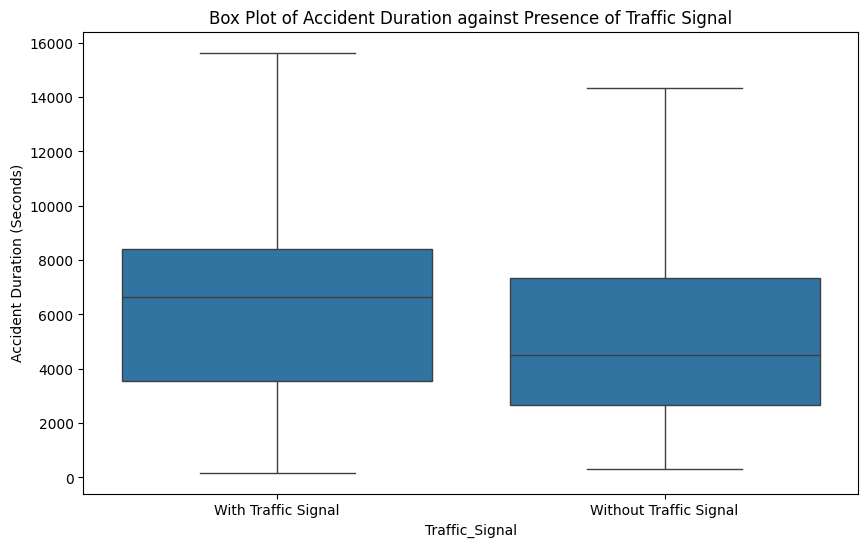

In [102]:
top_5_plot = top_5.copy()
top_5_plot['Traffic_Signal'] = top_5_plot['Traffic_Signal'].map({True: 'With Traffic Signal', False: 'Without Traffic Signal'})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Traffic_Signal', y='Accident_Duration', data=top_5_plot, showfliers=False)
plt.xticks([0, 1], ['With Traffic Signal', 'Without Traffic Signal'])
plt.ylabel('Accident Duration (Seconds)')
plt.title('Box Plot of Accident Duration against Presence of Traffic Signal')
plt.show()

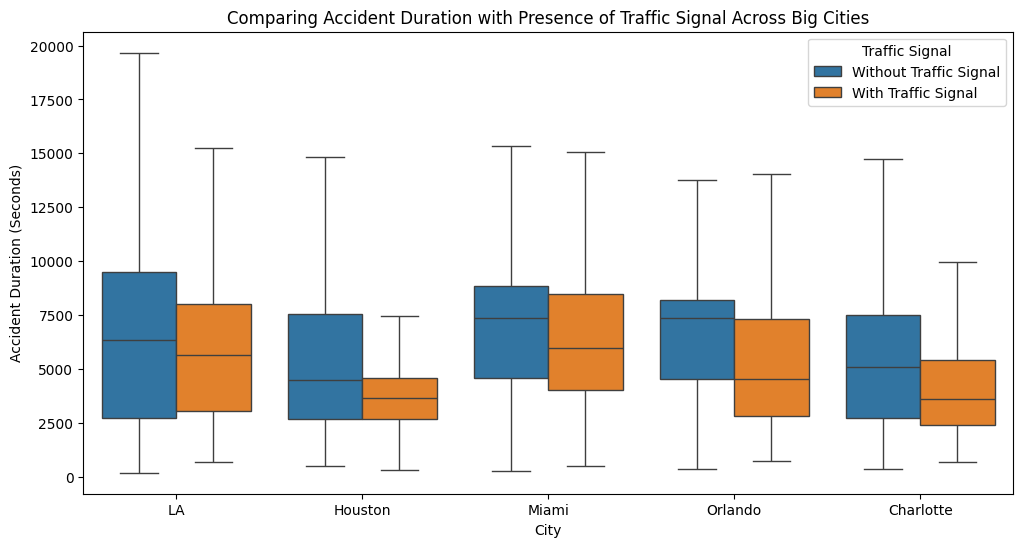

In [103]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='City', hue='Traffic_Signal', y='Accident_Duration', data=top_5_plot, showfliers=False)
plt.ylabel('Accident Duration (Seconds)')
plt.title('Comparing Accident Duration with Presence of Traffic Signal Across Big Cities')
plt.legend(title='Traffic Signal')
plt.show()

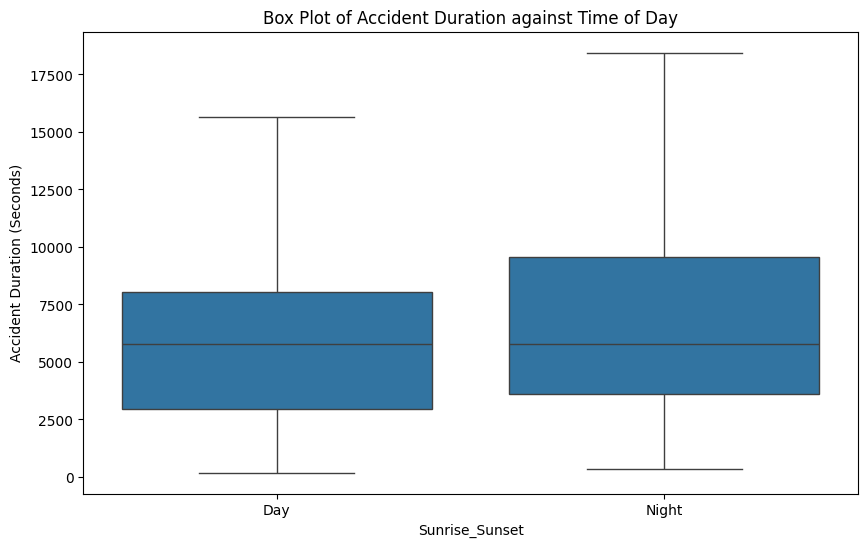

In [104]:
filtered_data = top_5.loc[top_5['Sunrise_Sunset'].isin(['Day', 'Night'])]

plt.figure(figsize=(10, 6))
sns.boxplot(x='Sunrise_Sunset', y='Accident_Duration', data=filtered_data, showfliers=False)
plt.xticks([0, 1], ['Day', 'Night'])
plt.ylabel('Accident Duration (Seconds)')
plt.title('Box Plot of Accident Duration against Time of Day')
plt.show()

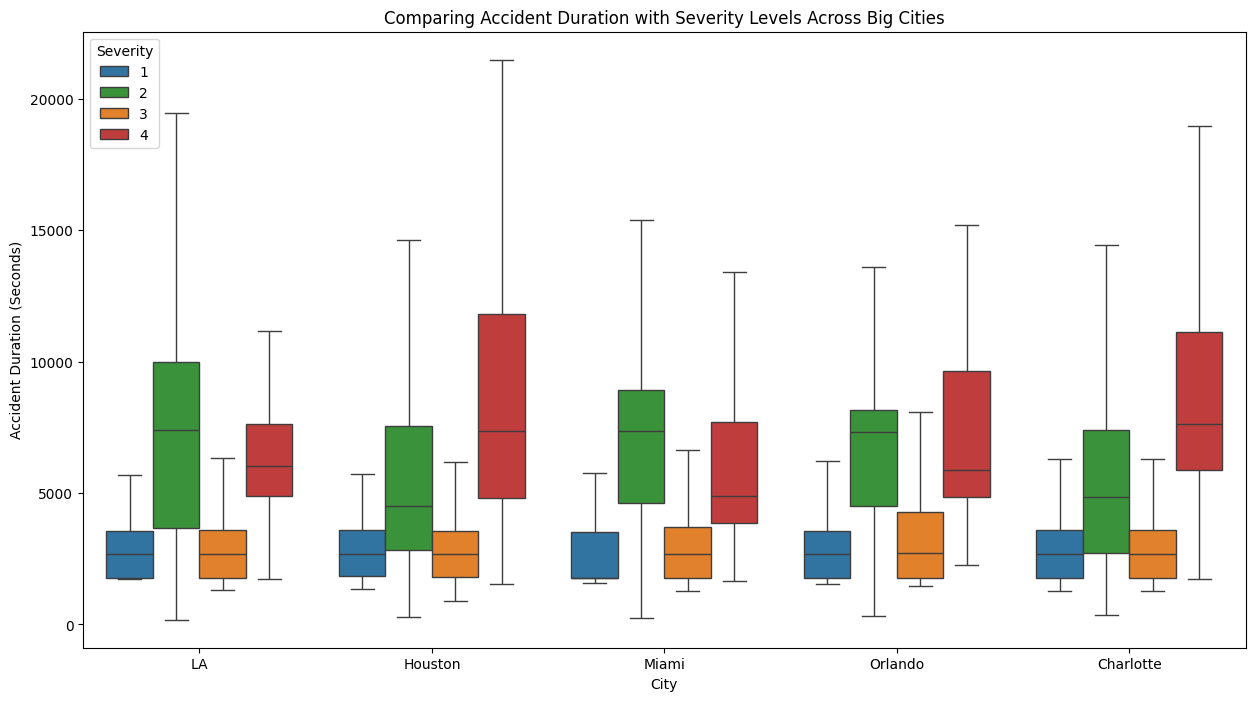

In [105]:
palette = {
    1: 'tab:blue',
    2: 'tab:green',
    3: 'tab:orange',
    4: 'tab:red',
}

plt.figure(figsize=(15, 8))
sns.boxplot(data = top_5_plot, x="City", hue = "Severity", y = 'Accident_Duration', palette = palette, showfliers = False)
plt.ylabel('Accident Duration (Seconds)')
plt.title('Comparing Accident Duration with Severity Levels Across Big Cities')
plt.legend(title='Severity')
plt.show()

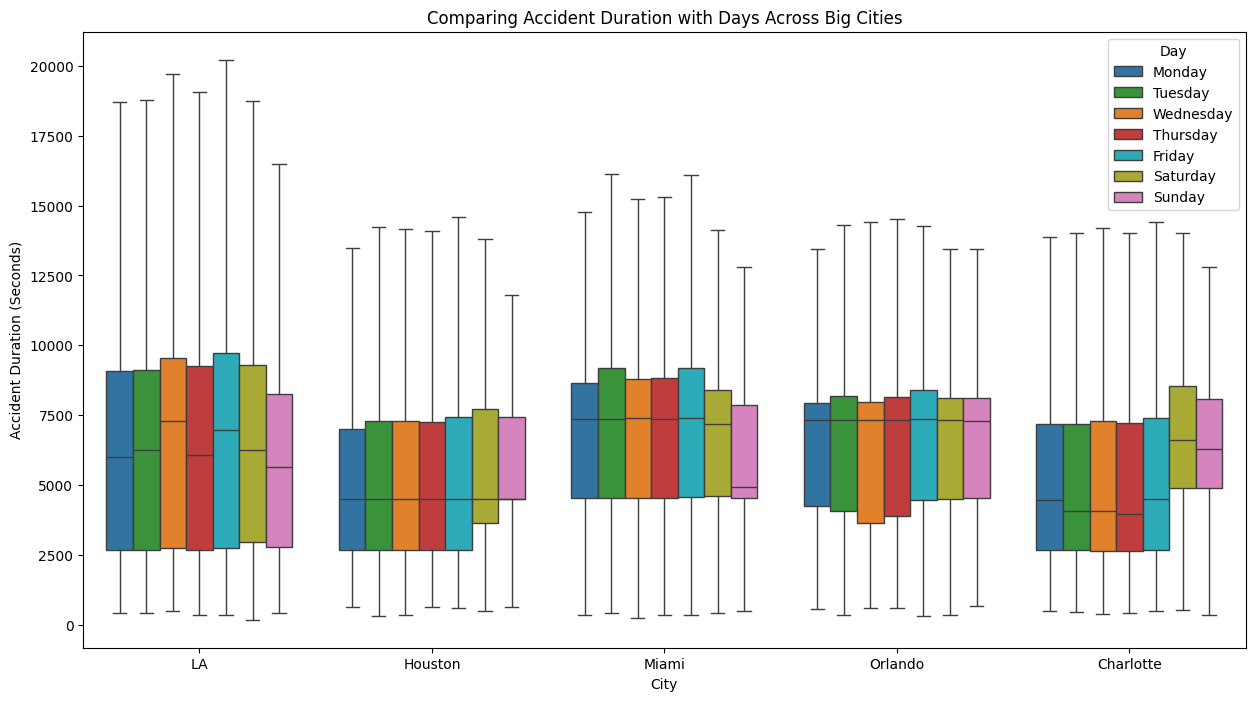

In [106]:
palette = {
    'Monday': 'tab:blue',
    'Tuesday': 'tab:green',
    'Wednesday': 'tab:orange',
    'Thursday': 'tab:red',
    'Friday': 'tab:cyan',
    'Saturday': 'tab:olive',
    'Sunday' : 'tab:pink'
}


plt.figure(figsize=(15, 8))
sns.boxplot(data = top_5_plot, x="City", hue = "Day", y = 'Accident_Duration', palette = palette,  hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], showfliers = False)
plt.ylabel('Accident Duration (Seconds)')
plt.title('Comparing Accident Duration with Days Across Big Cities')
plt.legend(title='Day')
plt.show()

## Data Preprocessing for Model

In [108]:
# One Hot Encoding all the main categorical features for the model
cols = ['City', 'Day', 'Sunrise_Sunset']

ohe = OneHotEncoder()
array_hot_encoded = ohe.fit_transform(top_5[cols]).toarray()
data_hot_encoded = pd.DataFrame(array_hot_encoded, columns = ohe.get_feature_names_out(), index=top_5.index)
data_other_cols = top_5.drop(columns = cols)
top_5 = pd.concat([data_hot_encoded, data_other_cols], axis=1)
top_5.head()

,City_Charlotte,City_Houston,City_LA,City_Miami,City_Orlando,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,...,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Accident_Duration,Accident_Duration_Minutes,Time_of_Incident
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,1757.0,29,2022-09-08 12:46:45
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,1779.0,29,2022-09-08 09:15:12
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,True,False,4520.0,15,2022-09-08 09:26:28
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,1771.0,29,2022-09-08 09:47:21
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,False,2671.0,44,2022-09-08 08:13:36


In [109]:
top_5.columns

Index(['City_Charlotte', 'City_Houston', 'City_LA', 'City_Miami',
       'City_Orlando', 'Day_Friday', 'Day_Monday', 'Day_Saturday',
       'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday',
       'Sunrise_Sunset_Day', 'Sunrise_Sunset_Night', 'Sunrise_Sunset_nan',
       'Severity', 'Distance', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Accident_Duration', 'Accident_Duration_Minutes',
       'Time_of_Incident'],
      dtype='object')

In [110]:
# Categorized accident duration into five categories 
top_5['ETA'] = 0
top_5.loc[(top_5['Accident_Duration'] >= 300) & (top_5['Accident_Duration'] <= 2340), 'ETA'] = 1
top_5.loc[(top_5['Accident_Duration'] >= 2400) & (top_5['Accident_Duration'] <= 4200), 'ETA'] = 2
top_5.loc[(top_5['Accident_Duration'] >= 4260) & (top_5['Accident_Duration'] <= 16500), 'ETA'] = 3
top_5.loc[(top_5['Accident_Duration'] > 16500), 'ETA'] = 4
top_5.head()

,City_Charlotte,City_Houston,City_LA,City_Miami,City_Orlando,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Accident_Duration,Accident_Duration_Minutes,Time_of_Incident,ETA
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,1757.0,29,2022-09-08 12:46:45,1
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,1779.0,29,2022-09-08 09:15:12,1
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,True,False,4520.0,15,2022-09-08 09:26:28,3
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,1771.0,29,2022-09-08 09:47:21,1
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,False,False,False,False,False,False,2671.0,44,2022-09-08 08:13:36,2


In [111]:
top_5.isnull().sum()

City_Charlotte                  0
City_Houston                    0
City_LA                         0
City_Miami                      0
City_Orlando                    0
Day_Friday                      0
Day_Monday                      0
Day_Saturday                    0
Day_Sunday                      0
Day_Thursday                    0
Day_Tuesday                     0
Day_Wednesday                   0
Sunrise_Sunset_Day              0
Sunrise_Sunset_Night            0
Sunrise_Sunset_nan              0
Severity                        0
Distance                        0
Temperature(F)               1007
Wind_Chill(F)                2431
Humidity(%)                  1074
Pressure(in)                  576
Visibility(mi)                977
Wind_Direction               2201
Wind_Speed(mph)              2201
Precipitation(in)             792
Weather_Condition             834
Amenity                         0
Bump                            0
Crossing                        0
Give_Way      

In [112]:
top_5 = top_5.dropna()

In [113]:
top_5.isnull().sum()

City_Charlotte               0
City_Houston                 0
City_LA                      0
City_Miami                   0
City_Orlando                 0
Day_Friday                   0
Day_Monday                   0
Day_Saturday                 0
Day_Sunday                   0
Day_Thursday                 0
Day_Tuesday                  0
Day_Wednesday                0
Sunrise_Sunset_Day           0
Sunrise_Sunset_Night         0
Sunrise_Sunset_nan           0
Severity                     0
Distance                     0
Temperature(F)               0
Wind_Chill(F)                0
Humidity(%)                  0
Pressure(in)                 0
Visibility(mi)               0
Wind_Direction               0
Wind_Speed(mph)              0
Precipitation(in)            0
Weather_Condition            0
Amenity                      0
Bump                         0
Crossing                     0
Give_Way                     0
Junction                     0
No_Exit                      0
Railway 

In [114]:
reg_cols = ['ETA', 'Severity', 'City_Charlotte', 'City_Houston', 'City_LA', 'City_Miami', 'City_Orlando',
       'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday',
       'Day_Tuesday', 'Day_Wednesday', 'Sunrise_Sunset_Day', 'Sunrise_Sunset_Night', 'Distance', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop']

top_5 = top_5[reg_cols]

In [115]:
train, test = train_test_split(top_5, test_size = 0.2, random_state = 42)

X_cols = ['Severity', 'City_Charlotte', 'City_Houston', 'City_LA', 'City_Miami', 'City_Orlando',
       'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday',
       'Day_Tuesday', 'Day_Wednesday', 'Sunrise_Sunset_Day', 'Sunrise_Sunset_Night', 'Distance', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']

X = train[X_cols]
y = train['ETA']

## Models

### Frequentist GLM

In [118]:
reg = sm.GLM.from_formula('ETA ~ Severity + City_Charlotte + City_Houston + City_LA + City_Miami + City_Orlando + Day_Friday + Day_Monday + Day_Saturday + Day_Sunday + Day_Thursday + Day_Tuesday + Day_Wednesday + Sunrise_Sunset_Day + Sunrise_Sunset_Night + Distance + Amenity + Bump + Crossing + Give_Way + Junction + No_Exit + Railway + Roundabout + Station + Stop + Traffic_Calming + Traffic_Signal + Turning_Loop', data = train, family = sm.families.Poisson()).fit()
                          
print(reg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    ETA   No. Observations:               205954
Model:                            GLM   Df Residuals:                   205927
Model Family:                 Poisson   Df Model:                           26
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.2037e+05
Date:                Sun, 05 May 2024   Deviance:                       66570.
Time:                        23:22:41   Pearson chi2:                 5.70e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.02324
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [119]:
train_pred = reg.predict(train)
train.loc[:, 'y_pred'] = train_pred
train.loc[:, 'y_pred'] = np.round(train["y_pred"]).astype(int)

test_pred = reg.predict(test)
test.loc[:, 'y_pred'] = test_pred
test.loc[:, 'y_pred'] = np.round(test["y_pred"]).astype(int)

In [120]:
train_rmse = np.mean((train["y_pred"] - train["ETA"]) ** 2) ** 0.5
test_rmse = np.mean((test["y_pred"] - test["ETA"]) ** 2) ** 0.5
print("Training set error for GLM model:", train_rmse)
print("Test set error for GLM model:", test_rmse)

Training set error for GLM model: 0.9023605927707026
Test set error for GLM model: 0.9048843403254763


In [121]:
train_accuracy = accuracy_score(train["ETA"], train["y_pred"])
test_accuracy = accuracy_score(test["ETA"], test["y_pred"])
print("Training set Accuracy for GLM model:", train_accuracy)
print("Test set Accuracy for GLM model:", test_accuracy)

Training set Accuracy for GLM model: 0.5295162997562562
Test set Accuracy for GLM model: 0.5284818116490901


### Nonparametric Method - Random Forest

In [123]:
rf =  RandomForestClassifier(random_state = 42).fit(X, y)

train_pred_rf = rf.predict(X)
train.loc[:, 'y_pred_rf'] = train_pred_rf

test_X = test[X_cols]
test_pred_rf = rf.predict(test_X)
test.loc[:, 'y_pred_rf'] = test_pred_rf

train_rmse_rf = np.mean((train["y_pred_rf"] - train["ETA"]) ** 2) ** 0.5
test_rmse_rf = np.mean((test["y_pred_rf"] - test["ETA"]) ** 2) ** 0.5

print("Training set error for Random Forest model:", train_rmse_rf)
print("Test set error for Random Forest model:    ", test_rmse_rf)

Training set error for Random Forest model: 0.5930797528406749
Test set error for Random Forest model:     0.9034021724842578


In [124]:
train_accuracy_rf = accuracy_score(train["ETA"], train_pred_rf)
test_accuracy_rf = accuracy_score(test["ETA"], test_pred_rf)
print("Training set Accuracy for Random Forest model:", train_accuracy_rf)
print("Test set Accuracy for Random Forest model:    ", test_accuracy_rf)

Training set Accuracy for Random Forest model: 0.8108024121891296
Test set Accuracy for Random Forest model:     0.6378449765969431
